In [1]:
from __future__ import print_function
import keras 
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os 
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import seaborn as sys
import pandas as pd 
from keras.models import load_model

Using TensorFlow backend.


In [2]:
num_class = 5
r,c = (224,224)
batch_size = 32

In [3]:
train_data_dir = 'train'
valid_data_dir = 'validation'

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  shear_range=0.3,
                                  zoom_range=0.3,
                                  width_shift_range=0.4,
                                  height_shift_range=0.4,
                                  horizontal_flip=True,
                                  fill_mode="nearest")

valid_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_gen = train_datagen.flow_from_directory(train_data_dir,
                                             target_size=(r,c),
                                             batch_size=batch_size,
                                             class_mode="categorical",
                                             shuffle=True)

valid_gen = valid_datagen.flow_from_directory(valid_data_dir,
                                             target_size=(r,c),
                                             batch_size=batch_size,
                                             class_mode="categorical",
                                             shuffle=True)
num_train = 24256
num_valid = 3006
epochs = 70

Found 24256 images belonging to 5 classes.
Found 3006 images belonging to 5 classes.


In [6]:
m = load_model('face_emotion_mobilenet.h5')

In [7]:
all_labels = ['Angry','Happy','Neutral','Sad','Surprise']

In [8]:
y_pred = m.predict_generator(valid_gen,num_valid//batch_size+1)

In [9]:
y_pred = np.argmax(y_pred,axis=1)

In [10]:
valid_gen.classes

array([0, 0, 0, ..., 4, 4, 4])

In [11]:
print("Confution matrix")
print(confusion_matrix(valid_gen.classes,y_pred))

Confution matrix
[[100 176  50  92  73]
 [192 301  96 134 156]
 [130 231  68  89 108]
 [110 217  72  99  96]
 [102 138  45  71  60]]


In [12]:
print("classification Repot")
print(classification_report(valid_gen.classes,y_pred,target_names=all_labels))
#print(classification_report(valid_gen.classes,y_pred))

classification Repot
              precision    recall  f1-score   support

       Angry       0.16      0.20      0.18       491
       Happy       0.28      0.34      0.31       879
     Neutral       0.21      0.11      0.14       626
         Sad       0.20      0.17      0.18       594
    Surprise       0.12      0.14      0.13       416

    accuracy                           0.21      3006
   macro avg       0.19      0.19      0.19      3006
weighted avg       0.21      0.21      0.20      3006



In [13]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(all_labels): # all_labels: no of the labels
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        auc_score = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

    return roc_auc_score(y_test, y_pred, average=average)
    

94/94 [==============================] - 13s 142ms/step


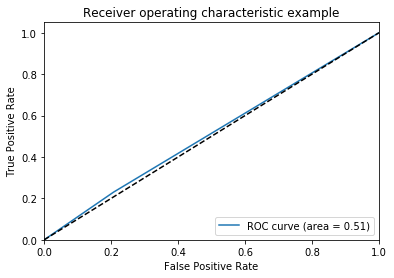

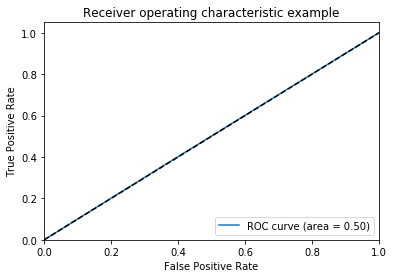

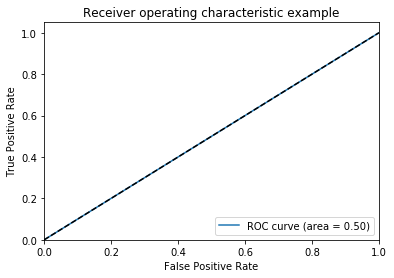

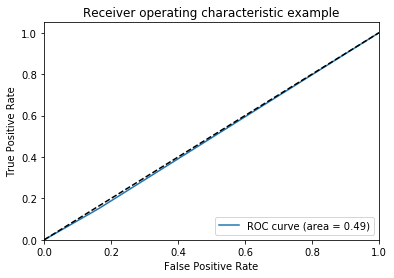

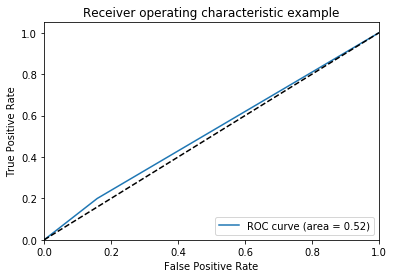

0.5053963181130052

In [14]:
valid_gen.reset()
y_pred = m.predict_generator(valid_gen,verbose=True)
y_pred = np.argmax(y_pred,axis=1)
multiclass_roc_auc_score(valid_gen.classes,y_pred)


In [15]:
con_mat = tf.math.confusion_matrix(labels=valid_gen.classes, predictions=y_pred).numpy()

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.


In [16]:
print(con_mat)

[[113 180  49  76  73]
 [188 312  95 147 137]
 [129 235  69  98  95]
 [138 186  75  90 105]
 [ 66 150  43  74  83]]


In [17]:
cf_mx_norm = np.around(con_mat.astype("float")/con_mat.sum(axis=1)[:,np.newaxis],decimals=2)

In [18]:
cf_mx_norm_df = pd.DataFrame(cf_mx_norm,index=all_labels,columns=all_labels)
cf_mx_norm_df

,Angry,Happy,Neutral,Sad,Surprise
Angry,0.23,0.37,0.10,0.15,0.15
Happy,0.21,0.35,0.11,0.17,0.16
Neutral,0.21,0.38,0.11,0.16,0.15
Sad,0.23,0.31,0.13,0.15,0.18
Surprise,0.16,0.36,0.10,0.18,0.20


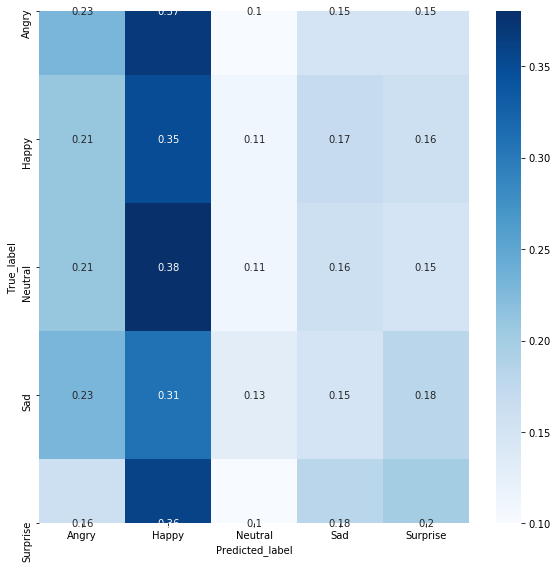

In [19]:
figure = plt.figure(figsize=(8,8))
sys.heatmap(cf_mx_norm_df,annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel("True_label")
plt.xlabel("Predicted_label")
plt.show()